# Modeling Pat Adoption with RandomForestClassifier

This notebook will use the Random Trees Algorithm for prediction of pet's adoption speed
- Metrics: Accuracy and Cohen's Weighted Kappa 
- Comparing model performance for cats and dogs combined vs. seperately. We will evaluate the overall accuracy for cats and dogs with 
  acc_combined_model = ((acc_cats * number_cats) + (acc_dogs * number_dogs))/(number_cats + number_dogs)

In [19]:
# importing necessary libraries and dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report, confusion_matrix

# import custom functions
from custom_functions import our_metrics, get_kappa

# display options
pd.set_option('display.max_rows', None)





# Import processed data - Cats and Dogs Combined

In [20]:
# import features
X_train = pd.read_csv('../data/petfinder-adoption-prediction/train/X_train_minmax_scaled_processed.csv')
X_test = pd.read_csv('../data/petfinder-adoption-prediction/train/X_test_minmax_scaled_processed.csv')

# import target
y_train = pd.read_csv('../data/petfinder-adoption-prediction/train/y_train.csv')
y_test = pd.read_csv('../data/petfinder-adoption-prediction/train/y_test.csv')

# turn target df into 1D-array
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()                  

# Import processed data - Cats and Dogs separated

# 

# Default Random Forest: cats and dogs, single and multiple listings

In [21]:
# instantiate and fit the default RFC on all features
rf_def_all = RandomForestClassifier()
rf_def_all.fit(X_train, y_train)

# predict target
rf_def_all_y_train_pred = rf_def_all.predict(X_train)
rf_def_all_y_test_pred = rf_def_all.predict(X_test)

# Average number of nodes and depths of trees in the forest
n_nodes = []
depths = []

for single_tree in rf_def_all.estimators_:
    n_nodes.append(single_tree.tree_.node_count)
    depths.append(single_tree.tree_.max_depth)

print('__________________________________')
print(f'Average number of nodes in the forest: {int(np.mean(n_nodes))}')
print('__________________________________')
print(f'Average depth trees in the forest: {int(np.mean(depths))}')
print(' ')
print(' ')

__________________________________
Average number of nodes in the forest: 10486
__________________________________
Average depth trees in the forest: 30
 
 


*** Model Evaluation: Predicting Train-Labels ***
Model Metrics and Normalized Confusion Matrix:
_____________________
Accuracy: 0.9929
_____________________
Weighted Quadratic Kappa: 0.9941


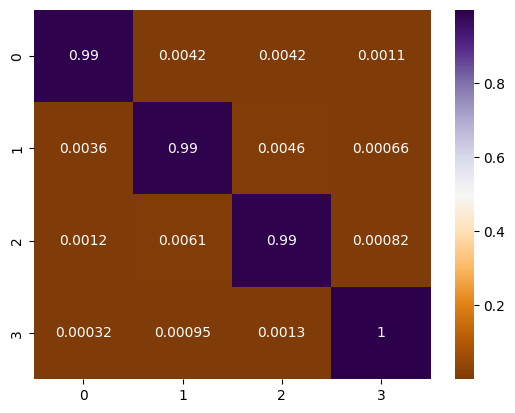

In [22]:
# Metrics predicting Train-Target
print('*** Model Evaluation: Predicting Train-Labels ***')
our_metrics(y_train, rf_def_all_y_train_pred)

*** Model Evaluation: Predicting Test-Labels ***
Model Metrics and Normalized Confusion Matrix:
_____________________
Accuracy: 0.3676
_____________________
Weighted Quadratic Kappa: 0.2367


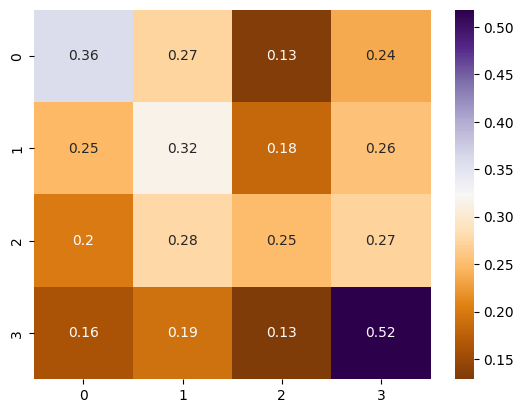

In [23]:
# Metrics predicting Test-Target
print('*** Model Evaluation: Predicting Test-Labels ***')
our_metrics(y_test, rf_def_all_y_test_pred)

__________________________________
Average number of nodes in the forest: 10495
__________________________________
Average depth trees in the forest: 30
 
 
__________________________________
Model Metrics and Normalized Confusion Matrix:
_____________________
Accuracy: 0.3822
_____________________
Weighted Quadratic Kappa: 0.248


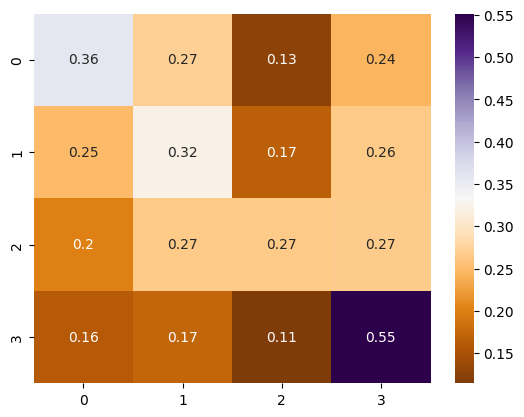

In [24]:





# instantiate and fit the default RFC on all features
rf_def_all = RandomForestClassifier()
rf_def_all.fit(X_train_minmax_scaled_processed, y_train)

# predict target

rf_def_all_y_pred = rf_def_all.predict(X_test_minmax_scaled_processed)

# Average number of nodes and depths of trees in the forest
n_nodes = []
depths = []

for single_tree in rf_def_all.estimators_:
    n_nodes.append(single_tree.tree_.node_count)
    depths.append(single_tree.tree_.max_depth)

print('__________________________________')
print(f'Average number of nodes in the forest: {int(np.mean(n_nodes))}')
print('__________________________________')
print(f'Average depth trees in the forest: {int(np.mean(depths))}')
print(' ')
print(' ')


# Model evaluation with custom function
print('__________________________________')
our_metrics(y_test, rf_def_all_y_pred, normalize=True)